# Driving Scene + Bounding Box GIF Generator

In [1]:
# Set path to the parent directory
import sys
sys.path.append('../') # let you import from parent directory

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# Import .py files and their functions
from bbox import rot, get_bbox
from utils import write_paths, write_labels, write_rotation_vectors, \
                    write_centroids, write_sizes, write_clouds, write_camera_matrices

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


class, Type, Label:
[['0' 'Unknown' '0']
 ['1' 'Compacts' '1']
 ['2' 'Sedans' '1']
 ['3' 'SUVs' '1']
 ['4' 'Coupes' '1']
 ['5' 'Muscle' '1']
 ['6' 'SportsClassics' '1']
 ['7' 'Sports' '1']
 ['8' 'Super' '1']
 ['9' 'Motorcycles' '2']
 ['10' 'OffRoad' '2']
 ['11' 'Industrial' '2']
 ['12' 'Utility' '2']
 ['13' 'Vans' '2']
 ['14' 'Cycles' '2']
 ['15' 'Boats' '0']
 ['16' 'Helicopters' '0']
 ['17' 'Planes' '0']
 ['18' 'Service' '0']
 ['19' 'Emergency' '0']
 ['20' 'Military' '0']
 ['21' 'Commercial' '0']
 ['22' 'Trains' '0']]

labels: [0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0]


## Training Data
- Scene Snapshots
- Bounding Boxes
  - Labels of Bounding Boxes
  - Rotation Vectors
  - Centroids (x, y, z)
  - Size of Bounding Box (Length, Width, Height)
- Point Clouds
- Camera Matrices

In [2]:
# Collect and save labels, centroids, point clouds, and camera matrices data
path = 'trainval' # path to folder containing training snapshots, bbox.bin, cloud.bin, proj.bin

# File Paths
if not os.path.exists('./trainval/trainval_paths.npy'):
    write_paths(path) # trainval_paths.npy

if not os.path.exists('./test/test_paths.npy'):
    write_paths('test') # test_paths.npy

# Labels of Bounding Boxes
if not os.path.exists('./trainval/trainval_labels.npy'):
    write_labels(path) # trainval_labels.npy

# Bounding Box Features - Rotation Vectors
if not os.path.exists('./trainval/trainval_rotation_vectors.npy'):
    write_rotation_vectors(path) # trainval_rotations.npy

# Bounding Box Features - Centroids
if not os.path.exists('./trainval/trainval_centroids.npy'):
    write_centroids(path) # trainval_centroids.npy

# Bounding Box Features - Sizes
if not os.path.exists('./trainval/trainval_sizes.npy'):
    write_sizes(path) # trainval_sizes.npy

# Point Clouds
if not os.path.exists('./trainval/trainval_pointclouds.npy'):
    write_clouds(path) # trainval_pointclouds.npy

# Camera Matrices
if not os.path.exists('./trainval/trainval_camera_matrices.npy'):
    write_camera_matrices(path) # trainval_camera_matrices.npy

### Labels & Feature Variables
- Scene Snapshots
- Bounding Boxes
  - Labels of Bounding Boxes
  - Rotation Vectors
  - Centroids (x, y, z)
  - Size of Bounding Box (Length, Width, Height)
- Point Clouds
- Camera Matrices

### Load Data

In [3]:
# Snapshots
train_snapshots = glob('trainval/*/*_image.jpg') # Grab all the snapshots

In [4]:
# Root directory for training data
train_root = './trainval/'
test_root = './test/'

# Load data
train_paths = np.load(train_root + 'trainval_paths.npy') # each training data's path (for reference)
test_paths = np.load(test_root + 'test_paths.npy') # each test data's path (for reference)
labels = np.load(train_root + 'trainval_labels.npy')
rotation_vectors = np.load(train_root + 'trainval_rotation_vectors.npy')
centroids = np.load(train_root + 'trainval_centroids.npy')
sizes = np.load(train_root + 'trainval_sizes.npy')
# point_clouds = np.load(train_root + 'trainval_pointclouds.npy', allow_pickle=True)
camera_matrices = np.load(train_root + 'trainval_camera_matrices.npy', allow_pickle=True)

### Custom Dataset
- **Our CustomDataset can handle horizontal flipping of the bounding box accordingly as the snapshot image is horizontally flipped.**
- **Our CustomDataset can handle resizing of the bounding box accordingly as the snapshot image is resized.**

In [5]:
class CustomDataset(Dataset):
    def __init__(self, snapshots, labels=None, rotation_vectors=None, 
                 centroids=None, sizes=None, camera_matrices=None, point_clouds=None,
                 flip_transform=None, norm_transform=None, resize_transform=None,
                 paths=None,
                 task='train'):
            
        self.task = task # task type

        if self.task == 'test':
            self.snapshots = snapshots # snapshot image
            self.paths = paths # each data's path (for reference)
        
        elif self.task == 'train':
            self.flip_transform = flip_transform # data augmentation
            self.norm_transform = norm_transform # data normalization
            self.resize_transform = resize_transform # data resizing
            
            self.snapshots = snapshots # snapshot images
            self.labels = labels # bounding boxes' labels
            self.rotation_vectors = rotation_vectors # bounding boxes' rotation vectors
            self.centroids = centroids # bounding boxes' centroids
            self.sizes = sizes # bounding boxes' sizes
            self.camera_matrices = camera_matrices # camera matrices
            self.point_clouds = point_clouds # point clouds
    
    def __len__(self):
        return len(self.snapshots)
    
    def __getitem__(self, idx):
        if self.task == 'test':
            snapshot = Image.open(self.snapshots[idx]) # snapshot image
            snapshot = transforms.ToTensor()(snapshot) # convert to tensor
            path = self.paths[idx] # each data's path (for reference)
            return snapshot, path

        elif self.task == 'train':
            snapshot = Image.open(self.snapshots[idx])
            snapshot = transforms.ToTensor()(snapshot) # convert to tensor

            if self.resize_transform is not None:
                original_height, original_width = snapshot.shape[1], snapshot.shape[2] # original image size
                snapshot = self.resize_transform(snapshot) # resizing
                new_height, new_width = snapshot.shape[1], snapshot.shape[2] # new image size
                height_scale = new_height / original_height # height scaling factor
                width_scale = new_width / original_width # width scaling factor
            
            # if self.norm_transform is not None:
            #     snapshot = self.norm_transform(snapshot) # normalization

            label = self.labels[idx] # label (vehicle type)
            rotation_vector = self.rotation_vectors[idx] # rotation vector (for 3D bounding box)
            centroid = self.centroids[idx] # centroid (for 3D bounding box)
            size = self.sizes[idx] # size (for 3D bounding box)
            camera_matrix = self.camera_matrices[idx] # camera matrix (for 3D bounding box)
            
            # If there is a flip transform method applied
            if self.flip_transform is not None:
                snapshot, bbox_coords = self.flip_transform(snapshot, rotation_vector, 
                                                            centroid, size, camera_matrix)
                
                # If there is a resize transform method applied
                if self.resize_transform is not None:
                    bbox_coords[:,[0,1]] *= width_scale # scale x coordinates (x_min, x_max)
                    bbox_coords[:,[2,3]] *= height_scale # scale y coordinates (y_min, y_max)

            # Else
            else:
                proj = camera_matrix
                
                R = rot(rotation_vector)
                t = centroid
                sz = size

                vert_3D, edges = get_bbox(-sz / 2, sz / 2)

                vert_3D = R @ vert_3D + t[:, np.newaxis]

                vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
                vert_2D = vert_2D / vert_2D[2, :]

                x_array = []
                y_array = []
                for e in edges.T:
                    x_array.append(vert_2D[0, e])
                    y_array.append(vert_2D[1, e])
                x_array = torch.tensor(x_array)
                y_array = torch.tensor(y_array)
                bbox_coords = torch.cat([x_array, y_array], dim=1) # [x_min, x_max, y_min, y_max]

                # If there is a resize transform method applied
                if self.resize_transform is not None:
                    bbox_coords[:,[0,1]] *= width_scale # scale x coordinates (x_min, x_max)
                    bbox_coords[:,[2,3]] *= height_scale # scale y coordinates (y_min, y_max)

            return snapshot, bbox_coords, label

# Image resize
resize_transform = transforms.Compose([
                    transforms.Resize((240, 480))
                    ])

### Dataset & DataLoader

In [6]:
# Dataset
trainval_dataset = CustomDataset(train_snapshots, labels=labels, rotation_vectors=rotation_vectors, 
                        centroids=centroids, sizes=sizes, camera_matrices=camera_matrices, 
                        flip_transform=None, norm_transform=None,
                        resize_transform=resize_transform,
                        task='train')

# Batch size
train_batch_size = 180

# Dataloader
train_dataloader = DataLoader(trainval_dataset, 
                            batch_size=train_batch_size, 
                            shuffle=False)


### A Sample Batch of Data From Dataloader

C:\Users\whdqk\AppData\Local\Temp\ipykernel_21488\3183759939.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  x_array = torch.tensor(x_array)


tensor([[430.1607, 420.1745,  91.0649,  76.8796],
        [430.5011, 419.8600,  77.3267,  90.9959],
        [393.9309, 394.1264,  92.7201,  80.4892],
        [393.9309, 430.1607,  92.7201,  91.0649],
        [430.5011, 394.1264,  77.3267,  80.4892],
        [430.5011, 430.1607,  77.3267,  91.0649],
        [393.9309, 383.8988,  92.7201,  92.6990],
        [394.1264, 384.0684,  80.4892,  80.1695],
        [430.1607, 419.8600,  91.0649,  90.9959],
        [430.5011, 420.1745,  77.3267,  76.8796],
        [383.8988, 384.0684,  92.6990,  80.1695],
        [383.8988, 419.8600,  92.6990,  90.9959],
        [420.1745, 384.0684,  76.8796,  80.1695],
        [420.1745, 419.8600,  76.8796,  90.9959]], dtype=torch.float64)
tensor(2, dtype=torch.uint8)


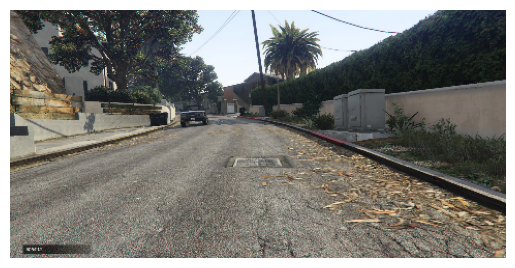

In [7]:
# Sampled random batch of data
data = next(iter(train_dataloader))

# Sampled snapshot
plt.imshow(data[0][11].numpy().transpose(1,2,0)) # C H W --> H W C
# axis = 'off' to remove axis
plt.axis('off')

# Bounding box coordinates
print(data[1][0]) # [x_min, x_max, y_min, y_max]

# Label
print(data[2][0]) # label (0, 1, or 2 --> classifying vehicle type)

### Sampled Bounding Box

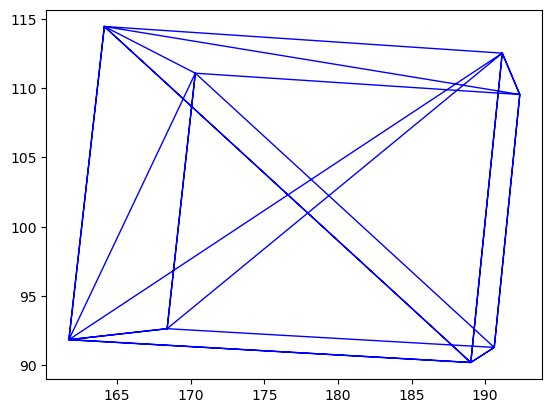

In [8]:
bbox_sample = data[1][11]
bbox_x_sample = bbox_sample[:,[0,1]].flatten() # x_min, x_max
bbox_y_sample = bbox_sample[:,[2,3]].flatten() # y_min, y_max
plt.plot(bbox_x_sample, bbox_y_sample, color='b', linewidth=1)
plt.show()

### Sampled Snapshot + Bounding Box

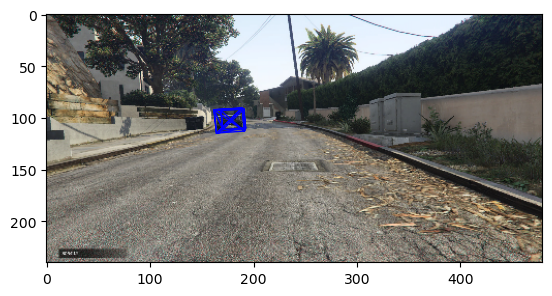

In [9]:
snapshot_sample = data[0][11]
plt.imshow(snapshot_sample.numpy().transpose(1,2,0)) # C H W --> H W C
plt.plot(bbox_x_sample, bbox_y_sample, color='b', linewidth=1)
plt.show()

In [ ]:
for i in range(100,180):
    fig, axs = plt.subplots(1, 2, figsize=(20, 16))
    snapshot_sample = data[0][i]
    bbox_sample = data[1][i]
    bbox_x_sample = bbox_sample[:,[0,1]].flatten() # x_min, x_max
    bbox_y_sample = bbox_sample[:,[2,3]].flatten() # y_min, y_max

    # snapshot
    axs[0].imshow(snapshot_sample.numpy().transpose(1,2,0)) # C H W --> H W C
    # + bounding box
    axs[0].plot(bbox_x_sample, bbox_y_sample, color='b', linewidth=1)
    axs[0].axis('off')

    # snapshot
    axs[1].imshow(snapshot_sample.numpy().transpose(1,2,0)) 
    plt.axis('off')

    plt.subplots_adjust(wspace=0)
    plt.savefig(f'images/fig{i}.png', bbox_inches='tight', pad_inches=0)
    plt.show()



In [17]:
import imageio
import os

# Set the directory containing the input image files
input_dir = "images/"

# Get a list of the input image file names
input_files = sorted(os.listdir(input_dir))

# Create a list of the image data as numpy arrays
images = []
for filename in input_files:
    filepath = os.path.join(input_dir, filename)
    image = imageio.imread(filepath)
    images.append(image)

# Create a GIF animation from the image data
output_path = "images/driving.gif"
imageio.mimsave(output_path, images, fps=3)

C:\Users\whdqk\AppData\Local\Temp\ipykernel_21488\3007143995.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)
